In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[0]
img_shape = org_img.shape
com_img = np.zeros(img_shape)

R = org_img[:,:,0]
G = org_img[:,:,1]
B = org_img[:,:,2]
HorizontalSize, VertivalSize = img_shape[:2]

In [3]:
# RGB信号を、輝度Y成分と色差UV成分に変換する

Y = np.zeros((VertivalSize, HorizontalSize))
U = np.zeros((VertivalSize, HorizontalSize))
V = np.zeros((VertivalSize, HorizontalSize))

for y in range(VertivalSize):
  for x in range(HorizontalSize):
    Y[y][x] =  R[y][x]*0.2990 + G[y][x]*0.5870 + B[y][x]*0.1140
    U[y][x] = -R[y][x]*0.1684 - G[y][x]*0.3316 + B[y][x]*0.5000
    V[y][x] =  R[y][x]*0.5000 - G[y][x]*0.4187 - B[y][x]*0.0813

C:\Users\naoki\AppData\Local\Temp\ipykernel_14920\1405615891.py:10: RuntimeWarning: overflow encountered in scalar negative
  U[y][x] = -R[y][x]*0.1684 - G[y][x]*0.3316 + B[y][x]*0.5000


In [4]:
# YUV成分から色差成分の間引きを行いMCUを構成する。また、輝度Y成分を[-128,+127]の範囲に変換する

YUV = np.zeros((6, 8, 8))

for y in range(8):
  for x in range(8):
    YUV[0][y][x] = Y[y][x] - 128
    YUV[1][y][x] = Y[y][x+8] - 128
    YUV[2][y][x] = Y[y+8][x] - 128
    YUV[3][y][x] = Y[y+8][x+8] - 128
    YUV[4][y][x] = U[y*2][x*2]
    YUV[5][y][x] = V[y*2][x*2]

In [5]:
# MCUと色差成分の間引き率4:1:1から輝度と色差成分YUVを作成する。また、輝度Y成分に128を加え、元の範囲に戻す。

for y in range(8):
  for x in range(8):
    Y[y][x] = YUV[0][y][x] + 128
    Y[y][x+8] = YUV[1][y][x] + 128
    Y[y+8][x] = YUV[2][y][x] + 128
    Y[y+8][x+8] = YUV[3][y][x] + 128
    U[y*2][x*2] = YUV[4][y][x]
    V[y*2][x*2] = YUV[5][y][x]

In [6]:
# 輝度と色差YUV成分をRGBの色信号に変換する

for y in range(VertivalSize):
  for x in range(HorizontalSize):
    R[y][x] = Y[y][x] + V[y][x]*1.4020
    if R[y][x] < 0:
      R[y][x] = 0
    elif R[y][x] > 255:
      R[y][x] = 255

    G[y][x] = Y[y][x] - U[y][x]*0.3441 - V[y][x]*0.7139
    if G[y][x] < 0:
      G[y][x] = 0
    elif G[y][x] > 255:
      G[y][x] = 255

    B[y][x] = Y[y][x] + U[y][x]*1.7718 - V[y][x]*0.0012
    if B[y][x] < 0:
      B[y][x] = 0
    elif B[y][x] > 255:
      B[y][x] = 255
      



In [24]:
# MCU内に存在する6個の8×8画素ブロックに対して2次元DCT変換を行う

DCT = np.zeros((6,8,8))

for v in range(8):
  if v == 0:
    cv = 1.0/np.sqrt(2.0)
  else:
    cv = 1.0
  for u in range(8):
    if u == 0:
      cu = 1.0/np.sqrt(2.0)
    else:
      cu = 1.0
    for k in range(6):
      sum = 0
      for y in range(8):
        for x in range(8):
          sum += YUV[k][y][x]*np.cos((2*x+1)*u*np.pi/16)*np.cos((2*y+1)*v*np.pi/16)
      DCT[k][v][u] = sum*cu*cv/4
    

In [ ]:
# MCU内に存在する6個の8×8DCT変換係数ブロックに対して量子化を行う

LuminanceQTable = [16, 11, 10, 16, 24, 40, 51, 61,
                   12, 12, 14, 19, 26, 58, 60, 55,
                   ]

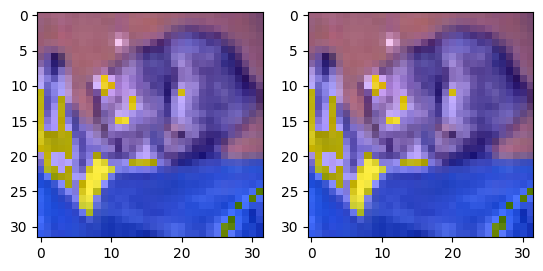

In [22]:
com_img[:,:,0] = R
com_img[:,:,1] = G
com_img[:,:,2] = B

com_img = com_img.astype('uint8')
org_img = org_img.astype('uint8')


plt.subplot(1, 2, 1)
plt.imshow(org_img)
plt.subplot(1, 2, 2)
plt.imshow(com_img)
plt.show()